## Building FootPrint Detection

In [1]:
import numpy as np
import cv2
import os 
from  glob import glob 
from matplotlib import pyplot as plt 

data_path = "/home/azureuser/cloudfiles/code/Users/samarth.tandon/data"
train_path = os.path.join(data_path,'train')
test_path = os.path.join(data_path,'test')

train_images = glob(train_path+'/Image/*.tif')
test_images = glob(test_path+'/Image/*.tif')

print("Training images: ",len(train_images))
print("Testing images: ",len(test_images))
print("IMG_shape: 1500x1500x3\n")

save_path = os.path.join(data_path,'models')
artifacts_path = os.path.join(data_path,'runs')

Training images:  3835
Testing images:  16
IMG_shape: 1500x1500x3



In [2]:
from azureml.core import Run
run = Run.get_context()

In [3]:
IMG_SHAPE = (512,512,3)
def remove_unwanted_files(train_input_dir,train_output_dir):
    ## Remove the images whose corresponding output mask image is not present 
    not_imgs = []
    for imgs in os.listdir(train_input_dir):
        out_img = os.path.join(train_output_dir,imgs)
        if not os.path.isfile(out_img):
            not_img = os.path.join(train_input_dir,imgs)
            os.remove(not_img)
        else:
            continue

def display_predictions(mask, groud_truth, img):
    fig, axs = plt.subplots(1,3, figsize=(8,7))
    axs[2].imshow(mask[:,:,0],cmap="gray")
    axs[2].set_title('Predicted')
    axs[1].imshow(groud_truth[:,:,0], cmap="gray")
    axs[1].set_title('GroundTruth')
    axs[0].imshow(img)
    axs[0].set_title('Map Input Image')
    plt.show()
    return 0
    
def plot_training_history(history):
    
    fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
    ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
    ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax_loss.legend()
    ax_acc.plot(history.epoch, history.history["iou_score"], label="Train iou")
    ax_acc.plot(history.epoch, history.history["val_iou_score"], label="Validation iou")
    ax_acc.legend()
    return 0

def get_sample_image(target_shape=IMG_SHAPE):
    image_name = test_images[np.random.randint(0,len(test_images))]
    mask_name = image_name.replace('test','test_labels')
    
    input_image = cv2.imread(image_name)
    input_image = cv2.cvtColor(cv2.resize(input_image,(IMG_SHAPE[0],IMG_SHAPE[1]),cv2.INTER_AREA),cv2.COLOR_BGR2RGB)

    mask_img = cv2.imread(mask_name)
    mask_img = cv2.resize(mask_img,(IMG_SHAPE[0],IMG_SHAPE[1]),cv2.INTER_AREA)
    
    input_image = input_image/255.0
    mask_img = mask_img/255.0
    return input_image,mask_img


def decode_segmentation_masks_gray(mask):
    gray = np.zeros_like(mask).astype(np.uint8)
    idx = mask > 0.5  # since sigmoid function is used in binary model
    gray[idx] = 255
    return gray

## Mask to BBOX

In [4]:
from skimage.measure import label, regionprops, find_contours

""" Convert a mask to border image """
def mask_to_border(mask):
    h, w = mask.shape
    border = np.zeros((h, w))

    contours = find_contours(mask, 128)
    for contour in contours:
        for c in contour:
            x = int(c[0])
            y = int(c[1])
            border[x][y] = 255

    return border

""" Mask to bounding boxes """
def mask_to_bbox(mask):
    bboxes = []

    mask = mask_to_border(mask)
    lbl = label(mask)
    props = regionprops(lbl)
    for prop in props:
        x1 = prop.bbox[1]
        y1 = prop.bbox[0]

        x2 = prop.bbox[3]
        y2 = prop.bbox[2]

        bboxes.append([x1, y1, x2, y2])

    return bboxes

def map_bboxes(boxes , image):
    x = image.copy()
    for bbox in boxes:
        x = cv2.rectangle(x, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (255, 0, 0), 2)
    return x

## Visualize the data

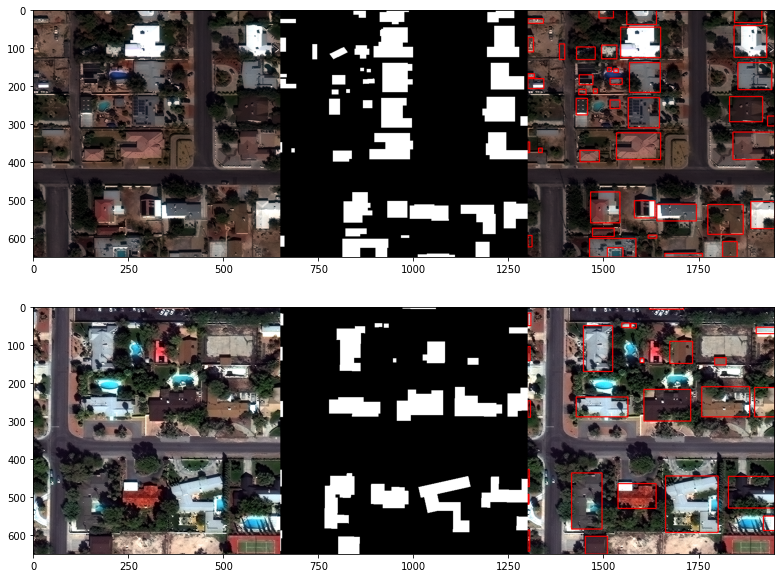

In [5]:
image_ids = np.random.choice(test_images, 2)

plt.figure(figsize=(20,10))
count = 0 
for image_id in image_ids:
    input_img = cv2.imread(image_id)
    input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)

    mask_img = cv2.imread(image_id.replace('Image','Mask')[:-3]+'png')
    mask_img = decode_segmentation_masks_gray(mask_img)
    mask_img_gray = cv2.cvtColor(mask_img,cv2.COLOR_RGB2GRAY)
    
    bbox = mask_to_bbox(mask_img_gray)
    mapped_image = map_bboxes(bbox,input_img)
    
    concat_img = cv2.hconcat([input_img,mask_img,mapped_image])
    count +=1
    if count>2:break 
    plt.subplot(2,1,count)
    plt.imshow(concat_img)

## Data Augmentation

In [6]:
# Add Augmentation 
import albumentations as A

def albu_transform_train():
    return A.Compose([A.RandomRotate90(p=0.1),
                      A.Transpose(p=0.5),
                      A.Blur(p=0.01, blur_limit = 3),
                      A.RandomBrightnessContrast(p=0.1),
                      A.OneOf([A.HorizontalFlip(p=0.5), A.VerticalFlip(p=0.5)],p=0.5)
                      ],p=1)

def albu_transform_valid():
    return A.Compose([A.HorizontalFlip(p=0.5), A.RandomBrightnessContrast(p=0.1)])

## Data Generator

In [7]:
from tensorflow.keras.utils import Sequence
class DataGenerator(Sequence):
    def __init__(self, image_files, mask_files, batch_size=1, image_size=512, shuffle=True, transform=None):
        """Initialization
        :param image_files: list of all images ids (file names)
        :param mask_files: list of mask labels (file names)
        :param batch_size: create batch of images
        :param image_size: path to masks location
        :param shuffle: True to shuffle label indexes after every epoch
        :param augment: To set augmentation Flag True/False
        """
        self.image_filenames = image_files
        self.mask_names = mask_files
        self.batch_size = batch_size
        self.image_shape = (image_size, image_size)
        self.list_IDs = np.arange(len(self.image_filenames))
        self.shuffle = shuffle
        self.augmentation = transform
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / (self.batch_size)))

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle: 
            np.random.shuffle(self.indexes)

    def read_image_mask(self, image_name, mask_name):
        input_img = cv2.imread(image_name)
        input_img = cv2.resize(input_img,self.image_shape,cv2.INTER_AREA)
        input_img = cv2.cvtColor(input_img,cv2.COLOR_BGR2RGB)
        input_img = input_img.astype(np.float32)

        mask_img = cv2.imread(mask_name)
        mask_img = cv2.cvtColor(cv2.resize(mask_img,self.image_shape,cv2.INTER_AREA) ,cv2.COLOR_BGR2GRAY)
        mask_img = np.expand_dims(mask_img,axis=-1)
        mask_img = self.decode_segmentation_masks_gray(mask_img)
        # mask_img = mask_img.astype(np.float32)
        return input_img/255.0, mask_img/255.0
    
    def transform_data(self,image,mask):
        transformed = self.augmentation(image=image, mask=mask)
        transform_image = transformed['image']
        transform_mask = transformed['mask']
        return transform_image,transform_mask

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Defining dataset
        X = np.empty((self.batch_size, self.image_shape[0], self.image_shape[1], 3),dtype=np.float32)
        Y = np.empty((self.batch_size, self.image_shape[0], self.image_shape[1], 1),dtype=np.float32)
        
        for i, index in enumerate(list_IDs_temp):
            X_sample, Y_sample = self.read_image_mask(self.image_filenames[index],self.mask_names[index])
            # X_sample, Y_sample = self.read_image_mask(self.image_filenames[index],self.mask_names[index])
            if self.augmentation is not None:
                X_sample, Y_sample = self.transform_data(X_sample,Y_sample)
            if self.batch_size == 1:
                X = np.reshape(X_sample,(1,X_sample.shape[0], X_sample.shape[1],3))
                Y = np.reshape(Y_sample,(1,Y_sample.shape[0], Y_sample.shape[1],1))
                return X,Y
            else:        
                X[i, ...] = X_sample
                Y[i, ...] = Y_sample
        return X, Y
    
    @staticmethod
    def decode_segmentation_masks_gray(mask):
        gray = np.zeros_like(mask).astype(np.uint8)
        idx = mask > 0.5  # since sigmoid function is used in binary model
        gray[idx] = 255
        return gray

In [8]:
mask_train_images = [img_name.replace('Image','Mask')[:-3]+'png' for img_name in train_images]
mask_test_images = [img_name.replace('Image','Mask')[:-3]+'png' for img_name in test_images]

print("mask Train Images ",len(mask_train_images))
print("mask test images ",len(mask_test_images))

mask Train Images  3835
mask test images  16


In [9]:
# setting generators
train_generator = DataGenerator(image_files= train_images, mask_files = mask_train_images, batch_size=1,transform=albu_transform_train())

test_generator = DataGenerator(image_files= test_images,mask_files=mask_test_images,batch_size=1)

Xtrain, ytrain = train_generator.__getitem__(3)
print("input size",Xtrain.shape,ytrain.shape)


input size (1, 512, 512, 3) (1, 512, 512, 1)


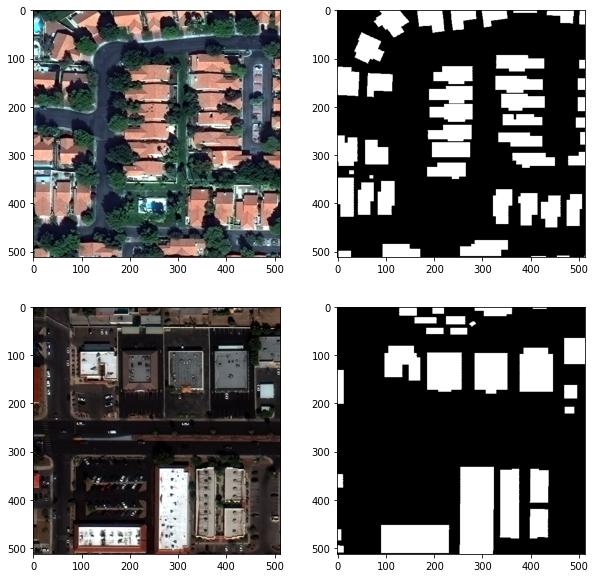

In [10]:
plt.figure(figsize=(10,10))
count = 0
for i in range(4):
    Xtest, ytest = test_generator.__getitem__(i*np.random.randint(0,10))
    output_img = ytest[0, :,:,0]
    
    if count>=4:break 
    count +=1
    plt.subplot(2,2,count)
    plt.imshow(Xtest[0])
    count +=1
    plt.subplot(2,2,count)
    plt.imshow(output_img,cmap='gray')

## Segmentation Model

In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import Sequence
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
import tensorflow_addons as tfa

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))


2.9.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
def jaccard_coef(y_true, y_pred):
    smooth = 1e-12
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    smooth = 1e-12
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred_pos, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)

    
def dice_metric(y_pred, y_true):
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    # if y_pred.sum() == 0 and y_pred.sum() == 0:
    #     return 1.0
    return 2*intersection / union

def infer(model, image_tensor):
    predictions = model.predict(np.expand_dims((image_tensor), axis=0))
    predictions = np.squeeze(predictions)
    predictions = np.argmax(predictions, axis=2)
    return predictions

In [34]:
def get_countours(mask_image):
    #get countours
    edged = cv2.Canny(mask_image, 0.5, 1)
    # Finding Contours
    contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return contours

def draw_countours(input_image,mask_image):
    output_image = input_image.copy()
    contours = get_countours(mask_image=mask_image)
    for contour in contours:
            cv2.drawContours(output_image, contour, -1, (0, 255, 0), 3)
    return output_image

def process_image(input_image,img_shape=(512,512)):
    target_image = cv2.resize(input_image,(IMG_SHAPE[0],IMG_SHAPE[1]),cv2.INTER_AREA)
    target_image = cv2.cvtColor(target_image,cv2.COLOR_BGR2RGB)
    target_image = target_image.astype(np.float32)
    return target_image/255.0


def test_segmentation_mask(image_list,model,n_to_show=10,IMG_SHAPE=(512,512)):
    random_images = np.random.choice(image_list,n_to_show) 
    figure = plt.figure(figsize=(75,45))

    for i,test_image_path in enumerate(random_images):
        input_image = cv2.imread(test_image_path)
        input_image = cv2.cvtColor(input_image,cv2.COLOR_BGR2RGB)
        mask_img = cv2.imread(test_image_path.replace('Image','Mask')[:-3]+'png')
        
        target_img = process_image(input_image=input_image,img_shape=(IMG_SHAPE[0],IMG_SHAPE[1]))
        
        mask_img = cv2.cvtColor(mask_img,cv2.COLOR_BGR2RGB)
        # mask_img = cv2.resize(mask_img,(IMG_SHAPE[0],IMG_SHAPE[1]),cv2.INTER_AREA)
        ground_truth = draw_countours(input_image=input_image,mask_image=mask_img)
        
        predicted_mask = np.squeeze(model.predict(np.expand_dims(target_img, axis=0)),axis=0) # normalize image before sending for prediction (512,512,1)
        predicted_mask = cv2.cvtColor(decode_segmentation_masks_gray(predicted_mask),cv2.COLOR_GRAY2BGR)
        predicted_mask = cv2.resize(predicted_mask,(input_image.shape[0],input_image.shape[1]))

        model_prediction = draw_countours(input_image=input_image,mask_image=predicted_mask)

        # gt_overlay = cv2.addWeighted(input_image,0.35,mask_img,0.65,1)
        # predicted_overlay = cv2.addWeighted(input_image, 0.35, predicted_mask, 0.65, 0)
        
        final_img = cv2.hconcat([ground_truth,model_prediction])

        sub = figure.add_subplot(n_to_show,2,i+1)
        sub.set_title("Model visualization(Ground truth/Predicted Mask)")
        sub.axis='off'
        sub.imshow(final_img)

# test_segmentation_mask(test_images,res_unet,n_to_show=1)

## Using Microsoft Efficient U7 model as UNET 

In [14]:
%env SM_FRAMEWORK=tf.keras
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import IOUScore 


BACKBONE = 'efficientnetb7'
preprocess_input = get_preprocessing(BACKBONE)
# load Model
eff_b7 = Unet(BACKBONE, encoder_weights='imagenet', classes=1)


env: SM_FRAMEWORK=tf.keras
Segmentation Models: using `tf.keras` framework.


In [15]:
print("Input Shape of Model :",eff_b7.input_shape)
print("Output shape of Model:",eff_b7.output_shape)

Input Shape of Model : (None, None, None, 3)
Output shape of Model: (None, None, None, 1)


In [16]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score
    
def bce_dice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return tf.keras.losses.binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def jaccard_distance_loss(y_true, y_pred, smooth=100):
    """
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))

    The jaccard distance loss is useful for unbalanced datasets. This has been
    shifted so it converges on 0 and is smoothed to avoid exploding or disapearing
    gradient.

    Ref: https://en.wikipedia.org/wiki/Jaccard_index
    """
    intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis=-1))
    sum_ = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis=-1))
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth

## Set Pretrained weights for any previously trained model 

In [17]:
pretrain = True
if pretrain:
    if os.listdir(save_path):
        pretrained_weights = tf.keras.models.load_model(save_path,custom_objects={'loss':bce_jaccard_loss,'dice_metric':dice_metric,'IOUScore':IOUScore()},compile=False)
        print("Total params in pretrained weights :",pretrained_weights.count_params())
        print("total Trainable params :",np.sum([tf.keras.backend.count_params(p) for p in pretrained_weights.trainable_weights]))
        print("total Non-trainable params :",np.sum([tf.keras.backend.count_params(p) for p in pretrained_weights.non_trainable_weights]))
        ## Set pretrained weights to current model
        eff_b7.set_weights(pretrained_weights.get_weights())
else:
    print("use pretrain is False")

Total params in pretrained weights : 75048097
total Trainable params : 74735393
total Non-trainable params : 312704


### Compile Model  

In [18]:
# define Metrics
metrics=['accuracy',dice_metric,jaccard_coef_int]
# Define Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# model Compile
eff_b7.compile(
    optimizer=optimizer,
    loss=bce_jaccard_loss,
    metrics=metrics
)

## Define Callback

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
# define Display Call abck
PATIENCE = 10

class LogToAzure(tf.keras.callbacks.Callback):
    '''Keras Callback for realtime logging to Azure'''
    def __init__(self, run):
        super(LogToAzure, self).__init__()
        self.run = run

    def on_train_batch_end(self, batch, logs=None):
        # Log all log data to Azure
        for k, v in logs.items():
            self.run.log(k, v)


class DisplayCallback(tf.keras.callbacks.Callback):
    def __init__(self, patience=10, save_path=None):
        super(DisplayCallback, self).__init__()
        self.patience = patience
        self.outpath = save_path

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.patience == 0:
            x_sample, y_sample = test_generator.__getitem__(np.random.randint(0, 10))
            if x_sample.shape[0] > 1:
                x_sample = x_sample[0]
                input_img = np.expand_dims(x_sample, axis=0)
            else:
                input_img = x_sample
            predicted_mask = self.model.predict(input_img)
            predicted_mask = np.reshape(predicted_mask, (predicted_mask.shape[1], predicted_mask.shape[2], 1))
            # predicted_mask = decode_segmentation_masks_gray(predicted_mask)
            cv2.imwrite(os.path.join(self.outpath, 'epoch_' + str(epoch + 1) + '_sample.png'), predicted_mask)

reduce_lr = ReduceLROnPlateau(monitor='val_dice_metric', factor=0.5, mode='max',patience=20, min_lr=0.0001)
# stop learining as metric on validatopn stop increasing
early_stopping = EarlyStopping(monitor='val_dice_metric',patience=5, verbose=1, mode='max')
#model checkpoint save
checkpoint = ModelCheckpoint(save_path, monitor='val_dice_metric', verbose=1, save_best_only=True,
                                     mode='max')
# Define Callbacks
callbacks = [checkpoint,early_stopping,DisplayCallback(patience=1,save_path=artifacts_path),LogToAzure(run),reduce_lr]


In [20]:
trainable_count = [tf.keras.backend.count_params(p) for p in eff_b7.trainable_weights]
non_trainable_count = [tf.keras.backend.count_params(p) for p in eff_b7.non_trainable_weights]

print("Total trainable params :",np.sum(trainable_count))
print("Non trainable Weights :",np.sum(non_trainable_count))

Total trainable params : 74735393
Non trainable Weights : 312704


In [21]:
EPOCHS = 50 
BATCH_SIZE = 1
# fit the model
history = eff_b7.fit(train_generator,epochs=EPOCHS,batch_size=1,verbose = 1,validation_data = test_generator,callbacks= callbacks)

Attempted to log scalar metric loss:
0.3850880563259125
Attempted to log scalar metric accuracy:
0.9633221626281738
Attempted to log scalar metric dice_metric:
0.812147855758667
Attempted to log scalar metric jaccard_coef_int:
0.8184486627578735
1930/3835 [==============>...............] - ETA: 31:23 - loss: 0.3851 - accuracy: 0.9633 - dice_metric: 0.8121 - jaccard_coef_int: 0.8184Attempted to log scalar metric loss:
0.3850865364074707
Attempted to log scalar metric accuracy:
0.9633082151412964
Attempted to log scalar metric dice_metric:
0.8121852874755859
Attempted to log scalar metric jaccard_coef_int:
0.8184165954589844
1931/3835 [==============>...............] - ETA: 31:22 - loss: 0.3851 - accuracy: 0.9633 - dice_metric: 0.8122 - jaccard_coef_int: 0.8184Attempted to log scalar metric loss:
0.3850928544998169
Attempted to log scalar metric accuracy:
0.963285505771637
Attempted to log scalar metric dice_metric:
0.812226414680481
Attempted to log scalar metric jaccard_coef_int:
0.818

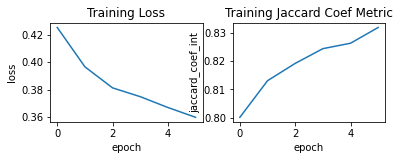

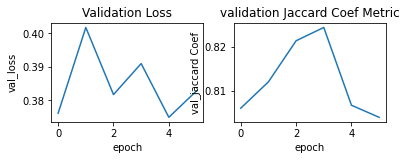

In [22]:
plt.subplot(2,2,1)
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")

plt.subplot(2,2,2)
plt.plot(history.history["jaccard_coef_int"])
plt.title("Training Jaccard Coef Metric")
plt.ylabel("jaccard_coef_int")
plt.xlabel("epoch")
plt.show()

plt.subplot(2,2,3)
plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")

plt.subplot(2,2,4)
plt.plot(history.history["val_jaccard_coef_int"])
plt.title("validation Jaccard Coef Metric")
plt.ylabel("val_jaccard Coef")
plt.xlabel("epoch")
plt.show()

## Run Inference on Test Images with Mapping Contours

1/1 [==============================] - 0s 121ms/step


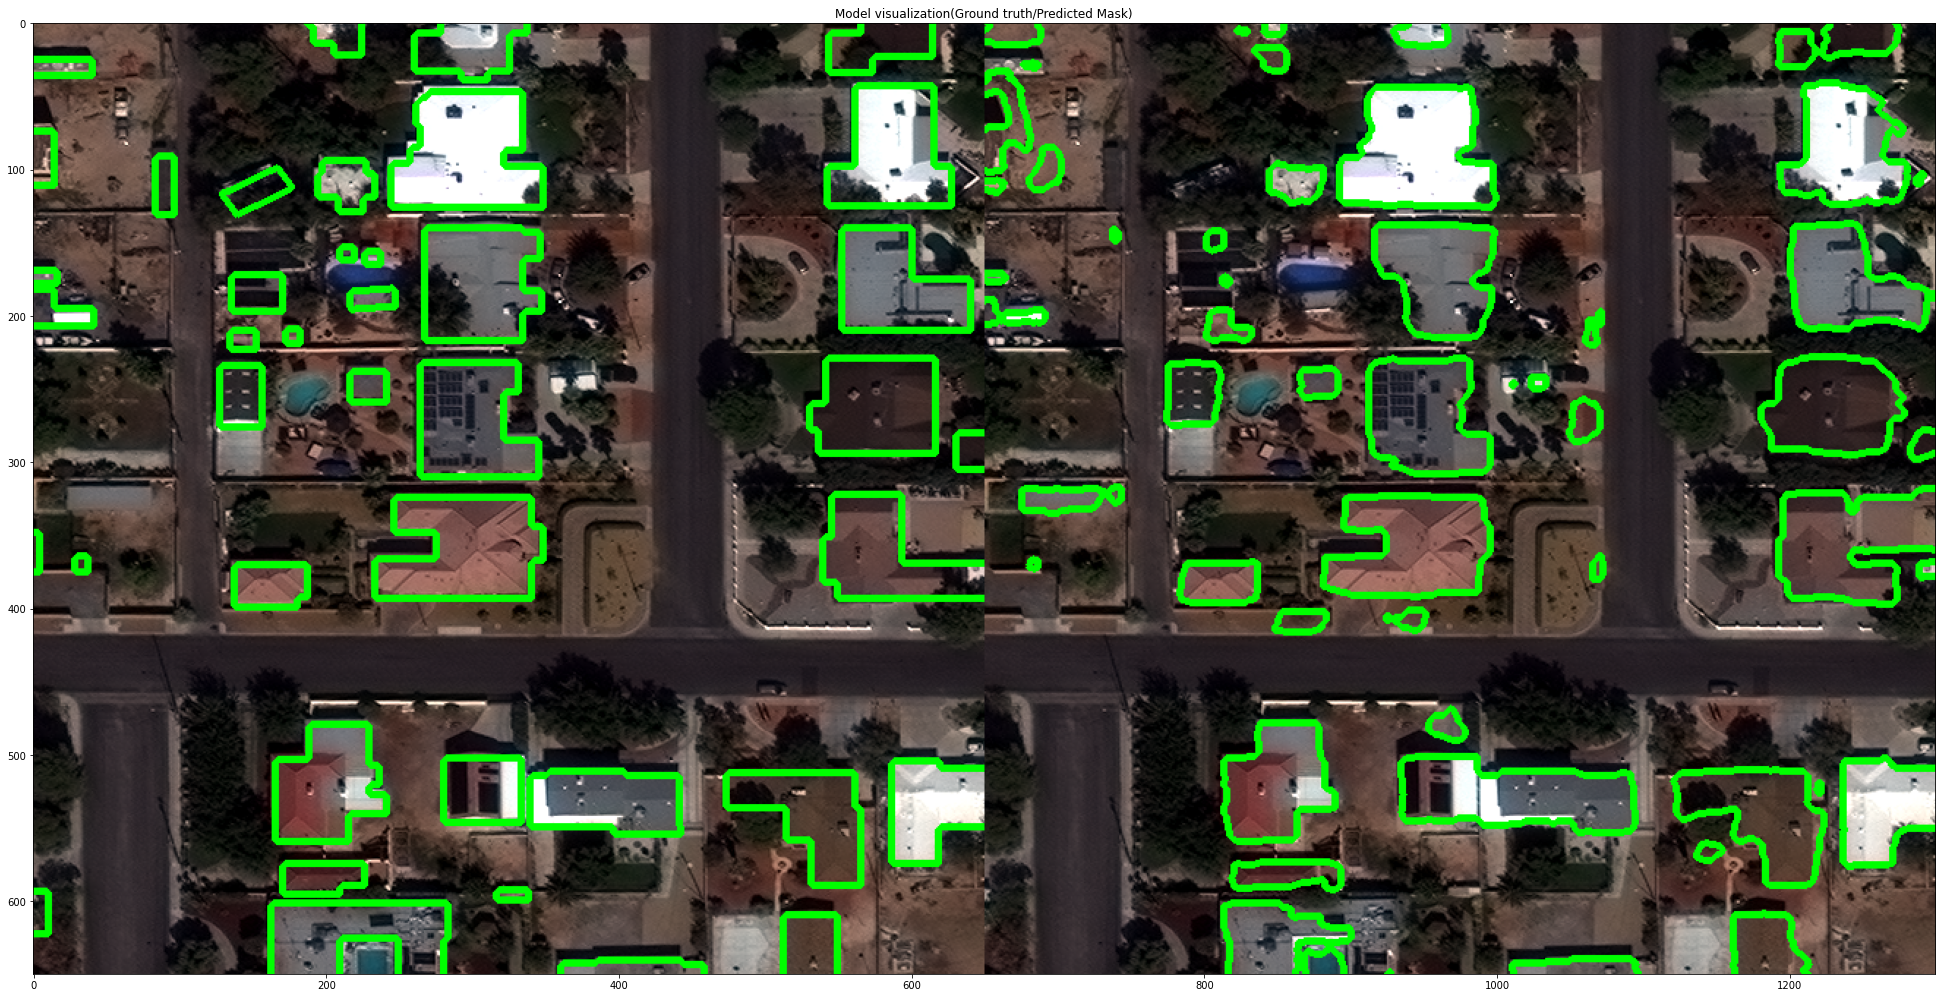

In [35]:
test_segmentation_mask(test_images,eff_b7,n_to_show=1)